<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center><img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'></center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej" 
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

**Solution author: Mateusz Doliński**

# Linear regression 

In this exercise you will use linear regression to predict flat prices. Training will be handled via gradient descent and we will:
* have multiple features (i.e. variables used to make the prediction),
* employ some basic feature engineering,
* work with a non-standard loss function.

Let's start with getting the data.

In [ ]:
%matplotlib inline

!wget -O mieszkania.csv https://www.dropbox.com/s/zey0gx91pna8irj/mieszkania.csv?dl=1
!wget -O mieszkania_test.csv https://www.dropbox.com/s/dbrj6sbxb4ayqjz/mieszkania_test.csv?dl=1

--2022-10-09 20:19:00--  https://www.dropbox.com/s/zey0gx91pna8irj/mieszkania.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/zey0gx91pna8irj/mieszkania.csv [following]
--2022-10-09 20:19:00--  https://www.dropbox.com/s/dl/zey0gx91pna8irj/mieszkania.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5e8529d9a363d74415fc07ff8c.dl.dropboxusercontent.com/cd/0/get/BujNMllE58kU5INe36mU5EQrFKBEsm3wmQhAiucuBe4z9P5OYApNr_8gr8QexJdMLjA4CaGqP7Ml-MwvvCZ1Y9bh4BAaGhrtWNDs2H3sVxX2_bKJZiNCDDx9hg3mJ45ruVyHgjmo35nhuRSq0sCwUCd_Mth7k8p238db_V3dvLtnHg/file?dl=1# [following]
--2022-10-09 20:19:01--  https://uc5e8529d9a363d74415fc07ff8c.dl.dropboxusercontent.com/cd/0/get/BujNMllE58kU5INe36mU5EQrFKBEsm3wmQhAiucuBe4z9P5OYApNr_8gr8QexJdMLjA4C

In [ ]:
!head mieszkania.csv mieszkania_test.csv

==> mieszkania.csv <==
m2,dzielnica,ilość_sypialni,ilość_łazienek,rok_budowy,parking_podziemny,cena
104,mokotowo,2,2,1940,1,780094
43,ochotowo,1,1,1970,1,346912
128,grodziskowo,3,2,1916,1,523466
112,mokotowo,3,2,1920,1,830965
149,mokotowo,3,3,1977,0,1090479
80,ochotowo,2,2,1937,0,599060
58,ochotowo,2,1,1922,0,463639
23,ochotowo,1,1,1929,0,166785
40,mokotowo,1,1,1973,0,318849

==> mieszkania_test.csv <==
m2,dzielnica,ilość_sypialni,ilość_łazienek,rok_budowy,parking_podziemny,cena
71,wolowo,2,2,1912,1,322227
45,mokotowo,1,1,1938,0,295878
38,mokotowo,1,1,1999,1,306530
70,ochotowo,2,2,1980,1,553641
136,mokotowo,3,2,1939,1,985348
128,wolowo,3,2,1983,1,695726
23,grodziskowo,1,1,1975,0,99751
117,mokotowo,3,2,1942,0,891261
65,ochotowo,2,1,2002,1,536499


Each row in the data represents a separate property. Our goal is to use the data from `mieszkania.csv` to create a model that can predict a property's price (i.e. `cena`) given its features (i.e. `m2,dzielnica,ilosc_sypialni,ilosc_lazienek,rok_budowy,parking_podziemny`). 

From now on, we should interfere only with `mieszkania.csv` (dubbed the training dataset) to make our decisions and create the model. The (only) purpose of `mieszkania_test.csv` is to test our model on **unseen** data.

Our predictions should minimize the so-called mean squared logarithmic error:
$$
MSLE = \frac{1}{n} \sum_{i=1}^n (\log(1+y_i) - \log(1+p_i))^2,
$$
where $y_i$ is the ground truth, and $p_i$ is our prediction.

Let's start with implementing the loss function.

In [ ]:
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from tqdm import tqdm

np.random.seed(357)
epsilon = 1e-7


In [ ]:
def load(name: str) -> Tuple[np.ndarray, np.array]:
    data = pd.read_csv(name)
    x = data.loc[:, data.columns != 'cena'].to_numpy()
    y = data['cena'].to_numpy()

    return x, y

In [ ]:
x_train, y_train = load('mieszkania.csv')
x_test, y_test = load('mieszkania_test.csv')

In [ ]:
labelencoder = preprocessing.LabelEncoder()
labelencoder.fit(x_train[:, 1])
x_train[:, 1] = labelencoder.transform(x_train[:, 1])
x_test[:, 1] = labelencoder.transform(x_test[:, 1])

x_train = x_train.astype(np.float64)
x_test = x_test.astype(np.float64)

In [ ]:
def log(x: np.ndarray) -> np.ndarray:
    return np.log(np.clip(x, epsilon, None))

In [ ]:
def mse(ys: np.array, ps: np.array) -> float:
  return np.mean((ys - ps)*(ys - ps))

In [ ]:
def msle(ys: np.array, ps: np.array) -> float:
    assert len(ys) == len(ps)
    #################################
    # TODO: Implement this function #
    #################################
    return np.mean((log(1+ys)-log(1+ps))**2)

The simplest model is predicting the same constant for each instance. Test your implementation of msle against outputing the mean price.

In [ ]:
###################################################
# TODO: Compute msle for outputing the mean price #
###################################################
msle(y_train, np.mean(y_train) * np.ones(y_train.shape))

0.3915253538257009

Recall that outputing the mean minimzes $MSE$. However, we're now dealing with $MSLE$.

Think of a constant that should result in the lowest $MSLE$.

Best constant:  431435.4915823427
MSLE for best constant 0.3648896122133589


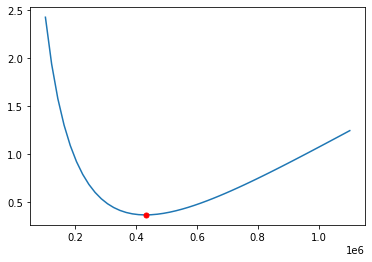

In [ ]:
#############################################
# TODO: Find this constant and compute msle #
#############################################
grid = np.linspace(y_train.min(), y_train.max())

msle_minimizing_constant = np.exp(np.mean(log(1 + y_train))) - 1
optimized_msle = msle(y_train, (np.exp(np.mean(log(1 + y_train))) - 1) * np.ones(y_train.shape))
print("Best constant: ", msle_minimizing_constant)
print("MSLE for best constant", optimized_msle)

msles = []
for point in grid:
    msles.append(msle(y_train, point * np.ones(y_train.shape)))

plt.plot(grid, msles)
plt.plot(
    msle_minimizing_constant, optimized_msle, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="red"
)
plt.show(
    np.exp(np.mean(log(1 + y_train))) - 1,
)

Now, let's implement a standard linear regression model. 

In [ ]:
##########################################################
# TODO: Implement linear regression and compute its msle #
##########################################################
def train(x: np.ndarray, y: np.array, alpha: int = 1e-7, max_iter: int = 100000) -> Tuple[np.array, float]:
    n_observations, n_features = x.shape

    k = 1 / n_features

    bias = np.mean(y)
    weights = np.random.uniform(
        low=-np.sqrt(k),
        high=np.sqrt(k),
        size=[
            n_features,
        ],
    )

    for i in tqdm(range(max_iter)):
        preds = (x @ weights + bias).squeeze()

        grad_bias = (2 / n_observations) * np.sum(preds - y)
        grad_weights = (2 / n_observations) * (x.T @ (preds - y))

        bias -= grad_bias * alpha
        weights -= grad_weights * alpha

        pred_after_update = (x @ weights + bias).squeeze()
        loss = mse(y, pred_after_update)
        if i % 2000 == 0:
            print("loss: ", loss)

    return bias, weights


bias, weights = train(x_train, y_train)

print("test error: ", msle(y_test, (x_test @ weights + bias).squeeze()))

  0%|          | 0/100000 [00:00<?, ?it/s]

loss:  73771742697.04982


  4%|▍         | 4102/100000 [00:00<00:04, 20697.55it/s]

loss:  33415658139.230667
loss:  20851224699.75516


  6%|▌         | 6172/100000 [00:00<00:04, 20625.94it/s]

loss:  16939195085.090261


  8%|▊         | 8242/100000 [00:00<00:04, 20654.56it/s]

loss:  15720931025.165205
loss:  15341321138.617613


 10%|█         | 10308/100000 [00:00<00:04, 20617.94it/s]

loss:  15222810943.634504


 14%|█▍        | 14406/100000 [00:00<00:04, 19869.89it/s]

loss:  15185589576.478853


 16%|█▋        | 16396/100000 [00:00<00:04, 19127.75it/s]

loss:  15173676263.311163


 18%|█▊        | 18467/100000 [00:00<00:04, 19598.94it/s]

loss:  15169642429.415249
loss:  15168062011.407202


 24%|██▍       | 24377/100000 [00:01<00:03, 19055.79it/s]

loss:  15167245704.935358
loss:  15166667576.186148
loss:  15166163885.161036


 31%|███       | 30734/100000 [00:01<00:03, 20539.19it/s]

loss:  15165683654.180569
loss:  15165211012.019732
loss:  15164741017.196508


 37%|███▋      | 36873/100000 [00:01<00:03, 20083.02it/s]

loss:  15164272131.00164
loss:  15163803874.11627


 41%|████      | 41124/100000 [00:02<00:02, 20616.81it/s]

loss:  15163336097.04333
loss:  15162868752.969887
loss:  15162401827.05207


 48%|████▊     | 47588/100000 [00:02<00:02, 21001.67it/s]

loss:  15161935314.399267
loss:  15161469213.219864
loss:  15161003522.687319


 54%|█████▍    | 53908/100000 [00:02<00:02, 20604.58it/s]

loss:  15160538242.27582
loss:  15160073371.553434
loss:  15159608910.11772


 58%|█████▊    | 58077/100000 [00:02<00:02, 19865.65it/s]

loss:  15159144857.575659
loss:  15158681213.537464
loss:  15158217977.61458


 64%|██████▍   | 64377/100000 [00:03<00:01, 20473.58it/s]

loss:  15157755149.419079
loss:  15157292728.563536
loss:  15156830714.660894


 71%|███████   | 70912/100000 [00:03<00:01, 21308.96it/s]

loss:  15156369107.32449
loss:  15155907906.168036
loss:  15155447110.80562


 77%|███████▋  | 77381/100000 [00:03<00:01, 21035.98it/s]

loss:  15154986720.851694
loss:  15154526735.921097


 82%|████████▏ | 81689/100000 [00:04<00:00, 20931.18it/s]

loss:  15154067155.629019
loss:  15153607979.591045
loss:  15153149207.423111


 88%|████████▊ | 88016/100000 [00:04<00:00, 20347.33it/s]

loss:  15152690838.741533
loss:  15152232873.163002
loss:  15151775310.304571


 92%|█████████▏| 92225/100000 [00:04<00:00, 20587.19it/s]

loss:  15151318149.783657
loss:  15150861391.218071
loss:  15150405034.225958


 99%|█████████▊| 98551/100000 [00:04<00:00, 20798.84it/s]

loss:  15149949078.42586
loss:  15149493523.436682


100%|██████████| 100000/100000 [00:04<00:00, 20295.39it/s]

test error:  0.0787396140949444


Note that the loss function that the algorithms optimizes (i.e $MSE$) differs from $MSLE$. We've already seen that this may result in a suboptimal solution.

How can you change the setting so that we optimze $MSLE$ instead?

Hint: 
<sub><sup><sub><sup><sub><sup>
Be lazy. We don't want to change the algorithm.
</sup></sub></sup></sub></sup></sub>

In [ ]:
#############################################
# TODO: Optimize msle and compare the error #
#############################################
def train(x: np.ndarray, y: np.array, alpha: int = 10000, max_iter: int = 10000) -> Tuple[np.ndarray, np.ndarray]:
    n_features = x.shape[1]

    k = 1 / n_features
    bias = np.exp(np.mean(log(1 + y)) - 1)
    weights = np.random.uniform(low=-np.sqrt(k), high=np.sqrt(k), size=[n_features, 1])

    for i in tqdm(range(max_iter)):
        preds = (x @ weights + bias).squeeze()

        grad_bias = 2 * np.mean((log(1 + y) - log(1 + preds)) * (-1 / (1 + preds)))
        grad_weights = (
            2 * np.mean(np.multiply(x, ((log(1 + y) - log(1 + preds)) * (-1 / (1 + preds))[np.newaxis, :]).T), axis=0)
        )[:, np.newaxis]

        bias -= grad_bias * alpha
        weights -= grad_weights * alpha

        pred_after_update = (x @ weights + bias).squeeze()
        loss = msle(y, pred_after_update)
        if i % 2000 == 0:
            print("loss: ", loss)

    return bias, weights


bias, weights = train(x_train, y_train)

print("test error: ", msle(y_test, (x_test @ weights + bias).squeeze()))

  4%|▍         | 444/10000 [00:00<00:04, 2089.21it/s]

loss:  0.5266775048334743


 23%|██▎       | 2308/10000 [00:00<00:03, 2264.73it/s]

loss:  0.21587627133552711


 45%|████▌     | 4540/10000 [00:01<00:02, 2386.55it/s]

loss:  0.13263827568214126


 65%|██████▍   | 6466/10000 [00:02<00:01, 2655.34it/s]

loss:  0.09058605744943435


 84%|████████▎ | 8354/10000 [00:03<00:00, 2417.03it/s]

loss:  0.07060606391797104


100%|██████████| 10000/10000 [00:03<00:00, 2540.55it/s]

test error:  0.0938314667014239


Without any feature engineering our model approximates the price as a linear combination of original features:
$$
\text{price} \approx w_1 \cdot \text{area} + w_2 \cdot \text{district} + \dots.
$$
Let's now introduce some interactions between the variables. For instance, let's consider a following formula:
$$
\text{price} \approx w_1 \cdot \text{area} \cdot \text{avg. price in the district per sq. meter} + w_2 \cdot \dots + \dots.
$$
Here, we model the price with far greater granularity, and we may expect to see more acurate results.

Add some feature engineering to your model. Be sure to play with the data and not with the algorithm's code. 

Think how to make sure that your model is capable of capturing the $w_1 \cdot \text{area} \cdot \text{avg. price...}$ part, without actually computing the averages.

Hint: 
<sub><sup><sub><sup><sub><sup>
Is having a binary encoding for each district and multiplying it by area enough?
</sup></sub></sup></sub></sup></sub>

Hint 2: 
<sub><sup><sub><sup><sub><sup>
Why not multiply everything together? I.e. (A,B,C) -> (AB,AC,BC).
</sup></sub></sup></sub></sup></sub>

In [ ]:
###############################################
# TODO: Implement the feature engineering part #
###############################################
def calculate_mean_district_prices_per_sq_meter(x: np.ndarray, y: np.array) -> Dict[str, float]:
    price_per_sq_meter = y / x[:, 0]
    mapping = {}

    for district in set(x[:, 1]):
        idxs_district = x[:, 1] == district
        mapping[district] = np.mean(price_per_sq_meter[idxs_district])
    return mapping


mean_district_prices_per_sq_meter = calculate_mean_district_prices_per_sq_meter(x_train, y_train)

x_train_new = np.c_[x_train, np.vectorize(lambda district: mean_district_prices_per_sq_meter[district])(x_train[:, 1])]
x_test_new = np.c_[x_test, np.vectorize(lambda district: mean_district_prices_per_sq_meter[district])(x_test[:, 1])]

In [ ]:
##############################################################
# TODO: Test your solution on the training and test datasets #
##############################################################
bias, weights = train(x_train_new, y_train, alpha=100)

print('test error: ', msle(y_test, (x_test_new @ weights + bias).squeeze()))

  2%|▏         | 195/10000 [00:00<00:05, 1942.69it/s]

loss:  0.8164056447358325


 25%|██▍       | 2457/10000 [00:01<00:03, 2090.34it/s]

loss:  0.31934115027032367


 43%|████▎     | 4316/10000 [00:01<00:02, 2516.02it/s]

loss:  0.31506359316363847


 63%|██████▎   | 6338/10000 [00:02<00:01, 2715.90it/s]

loss:  0.3120229050568548


 83%|████████▎ | 8339/10000 [00:03<00:00, 2520.82it/s]

loss:  0.3096483322726378


100%|██████████| 10000/10000 [00:04<00:00, 2493.48it/s]

test error:  0.3276191205152844
